# 0. Import packages

In [1]:
# Connect google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# 1. Load Base Datasets

In [3]:
INPUT_DIR='/content/drive/MyDrive/2023S/IE343/project/data/input'
OUTPUT_DIR='/content/drive/MyDrive/2023S/IE343/project/data/output'

In [4]:
## Do not change this cell. 
## The reason for this is to prevent cheating using the original data from DACON. 
## If an assertion error occurs in that cell when TAs evaluate the submitted code of each student, it is considered cheating.

train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
park = pd.read_csv(os.path.join(INPUT_DIR, 'park.csv'))
dcc = pd.read_csv(os.path.join(INPUT_DIR, 'day_care_center.csv'))

assert train.shape[0] == 329690 and train.shape[1] == 13, 'Do not change the format of the input data.'
assert test.shape[0] == 85097 and test.shape[1] == 12, 'Do not change the format of the input data.'
assert park.shape[0] == 1359 and park.shape[1] == 7, 'Do not change the format of the input data.'
assert dcc.shape[0] == 7373 and dcc.shape[1] == 10, 'Do not change the format of the input data.'
print(train.shape, test.shape, park.shape, dcc.shape)

(329690, 13) (85097, 12) (1359, 7) (7373, 10)


In [5]:
train

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE
0,0,0,busan,197,125.865988,1993,5,35.149929,129.006071,2021,7,11~20,229250.80
1,1,0,busan,197,101.647190,1993,12,35.149929,129.006071,2021,10,1~10,215320.00
2,2,0,busan,197,91.511175,1993,6,35.149929,129.006071,2020,3,21~31,161740.00
3,3,0,busan,197,101.647190,1993,13,35.149929,129.006071,2020,5,11~20,199781.80
4,4,0,busan,197,101.647190,1993,4,35.149929,129.006071,2022,6,21~30,219606.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,329685,4419,seoul,37,101.431912,2014,4,37.452039,127.070842,2022,5,21~31,885070.00
329686,329686,4419,seoul,37,101.431912,2014,14,37.452039,127.070842,2021,10,1~10,826132.00
329687,329687,4419,seoul,37,71.687641,2014,2,37.452039,127.070842,2022,11,21~30,697540.00
329688,329688,4419,seoul,37,137.192013,2014,18,37.452039,127.070842,2020,9,21~30,870656.98


In [6]:
test

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day
0,329690,0,busan,197,101.647190,1993,3,35.149929,129.006071,2023,1,21~31
1,329691,0,busan,197,91.511175,1993,12,35.149929,129.006071,2023,2,1~10
2,329692,0,busan,197,125.865988,1993,2,35.149929,129.006071,2023,2,11~20
3,329693,0,busan,197,101.647190,1993,8,35.149929,129.006071,2023,2,21~28
4,329694,0,busan,197,101.647190,1993,13,35.149929,129.006071,2023,3,21~31
...,...,...,...,...,...,...,...,...,...,...,...,...
85092,414782,4419,seoul,37,100.821957,2014,8,37.452039,127.070842,2023,10,21~31
85093,414783,4419,seoul,37,101.431912,2014,11,37.452039,127.070842,2023,10,21~31
85094,414784,4419,seoul,37,121.201627,2014,12,37.452039,127.070842,2023,11,1~10
85095,414785,4419,seoul,37,137.192013,2014,3,37.452039,127.070842,2023,11,21~30


In [7]:
park

,city,gu,dong,park_name,park_type,park_area,park_open_year
0,seoul,23,222,00024j4ovqt3gs6vu6ti,children park,68.992753,2008.0
1,seoul,3,227,00550wcaw8dcg0x4u2f2,neighborhood park,957.700371,1977.0
2,seoul,30,169,01295oe9jrn060obsgfi,neighborhood park,108.990825,2003.0
3,seoul,3,93,02ayq04uy1oz571dp87i,neighborhood park,98.608316,1990.0
4,seoul,21,226,02puz8uy9c7u2x47zhkj,children park,17.146428,1970.0
...,...,...,...,...,...,...,...
1354,seoul,13,194,zudccmxsd2nucbn6e6eo,children park,39.204592,2006.0
1355,seoul,24,84,zv3urzhrt0ghxdn2i6qi,neighborhood park,144.416758,NaN
1356,busan,27,152,zvddij1riig7fxdl2o9k,children park,36.701499,1965.0
1357,seoul,24,84,zxqxz1bym2cqb36ifdiv,children park,68.447060,NaN


In [ ]:
dcc

,city,gu,day_care_name,day_care_type,day_care_baby_num,teacher_num,nursing_room_num,playground_num,CCTV_num,is_commuting_vehicle
0,seoul,2,019dlft759nepobxqft2,national/public,49,9.0,NaN,NaN,NaN,
1,seoul,31,029xz1jtrlpcf9u5sq3i,home,20,4.0,4.0,0.0,0.0,N
2,seoul,3,02e04o0l2br7swfds7jn,private,49,9.0,NaN,NaN,NaN,Y
3,seoul,3,02e04o0l2br7swfds7jn,private,49,9.0,NaN,NaN,NaN,Y
4,busan,14,02e04o0l2br7swfds7jn,home,20,6.0,4.0,0.0,4.0,Y
...,...,...,...,...,...,...,...,...,...,...
7368,seoul,26,zzmuzxowbztizec6dj11,private,28,6.0,NaN,NaN,5.0,N
7369,seoul,3,zzqq55uk81jpkvnrrbni,private,73,11.0,NaN,NaN,NaN,Y
7370,busan,19,zzqq55uk81jpkvnrrbni,home,20,6.0,3.0,0.0,4.0,Y
7371,seoul,3,zzqq55uk81jpkvnrrbni,private,73,11.0,NaN,NaN,NaN,Y


# 2. Load additional dataset
- You can use any additional data source, **excluding the original dataset from [DACON](https://dacon.io/competitions/open/21265/data)**

# 3. EDA and Preprocessing

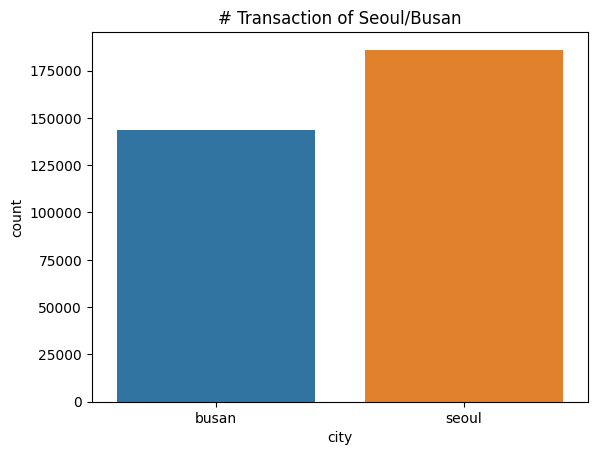

In [ ]:
sns.countplot(x='city', data=train)
plt.title('# Transaction of Seoul/Busan')
plt.show()

In [ ]:
# encoding city features

train['city'] = train['city'].replace('busan', 0)
train['city'] = train['city'].replace('seoul', 1)

test['city'] = test['city'].replace('busan', 0)
test['city'] = test['city'].replace('seoul', 1)

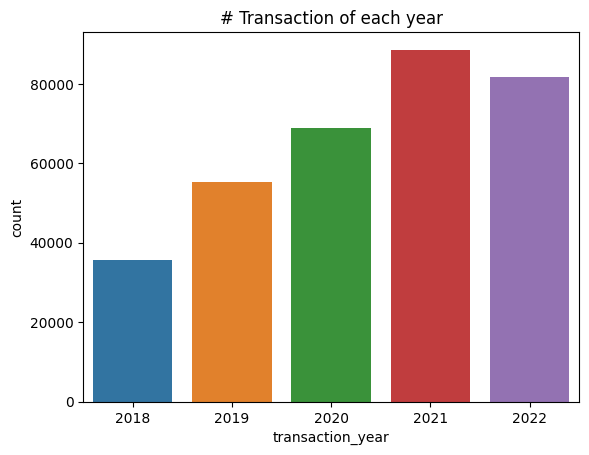

In [ ]:
sns.countplot(x='transaction_year', data=train)
plt.title('# Transaction of each year')
plt.show()

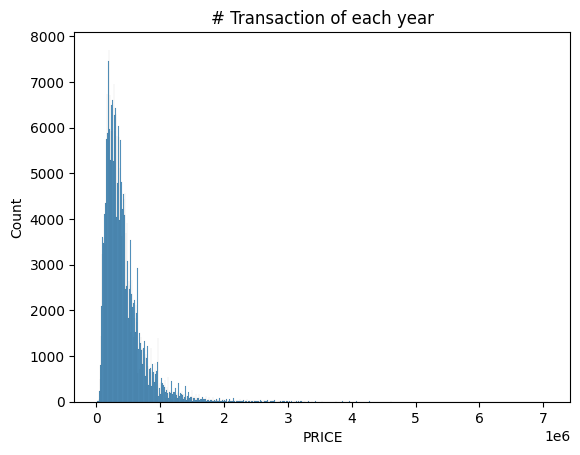

In [ ]:
sns.histplot(x='PRICE', data=train)
plt.title('# Transaction of each year')
plt.show()

In [ ]:
# convert PRICE to log(PRICE)

train['log_PRICE'] = np.log(train['PRICE'])

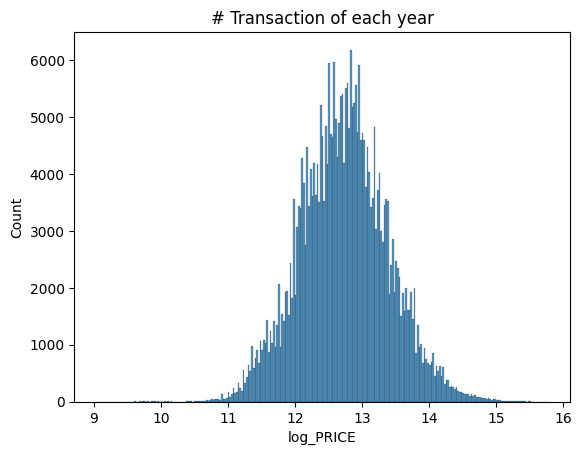

In [ ]:
sns.histplot(x='log_PRICE', data=train)
plt.title('# Transaction of each year')
plt.show()

In [ ]:
#fill NaN (long, lat features)

train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [ ]:
# encoding transaction_day features

train['transaction_day'] = train['transaction_day'].replace('1~10', 0)
train['transaction_day'] = train['transaction_day'].replace('11~20', 1)
train['transaction_day'] = train['transaction_day'].replace('21~28', 2)
train['transaction_day'] = train['transaction_day'].replace('21~29', 2)
train['transaction_day'] = train['transaction_day'].replace('21~30', 2)
train['transaction_day'] = train['transaction_day'].replace('21~31', 2)

test['transaction_day'] = test['transaction_day'].replace('1~10', 0)
test['transaction_day'] = test['transaction_day'].replace('11~20', 1)
test['transaction_day'] = test['transaction_day'].replace('21~28', 2)
test['transaction_day'] = test['transaction_day'].replace('21~29', 2)
test['transaction_day'] = test['transaction_day'].replace('21~30', 2)
test['transaction_day'] = test['transaction_day'].replace('21~31', 2)

In [ ]:
# make transaction_year_month feature

train['transaction_year_month'] = (train['transaction_year'])*12 + train['transaction_month']
test['transaction_year_month'] = (test['transaction_year'])*12 + test['transaction_month']

# min( min(train['transaction_year_month']), min(test['transaction_year_month']) ) = 24217

train['transaction_year_month'] = train['transaction_year_month'] - 24217
test['transaction_year_month'] = test['transaction_year_month'] - 24217

In [ ]:
# seoul and busan have same dong -> convert to unique value

train['dong'] = train['dong']+train['city']*1000
test['dong'] = test['dong']+test['city']*1000

In [ ]:
# make x,y,z coordinate features

train['x'] = np.cos(train['lat']) * np.cos(train['long'])
train['y'] = np.cos(train['lat']) * np.sin(train['long'])
train['z'] = np.sin(train['lat'])

test['x'] = np.cos(test['lat']) * np.cos(test['long'])
test['y'] = np.cos(test['lat']) * np.sin(test['long'])
test['z'] = np.sin(test['lat'])

In [ ]:
# processed train dataset

train

,index,apartment_id,city,dong,house_area,built_year,floor,lat,long,transaction_year,transaction_month,transaction_day,PRICE,transaction_year_month,log_PRICE,x,y,z
0,0,0,0,197,125.865988,1993,5,35.149929,129.006071,2021,7,1,229250.80,42,12.342572,0.812933,0.165443,-0.558362
1,1,0,0,197,101.647190,1993,12,35.149929,129.006071,2021,10,0,215320.00,45,12.279881,0.812933,0.165443,-0.558362
2,2,0,0,197,91.511175,1993,6,35.149929,129.006071,2020,3,2,161740.00,26,11.993745,0.812933,0.165443,-0.558362
3,3,0,0,197,101.647190,1993,13,35.149929,129.006071,2020,5,1,199781.80,28,12.204981,0.812933,0.165443,-0.558362
4,4,0,0,197,101.647190,1993,4,35.149929,129.006071,2022,6,2,219606.40,53,12.299592,0.812933,0.165443,-0.558362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329685,329685,4419,1,1037,101.431912,2014,4,37.452039,127.070842,2022,5,2,885070.00,52,13.693422,0.157983,0.956676,-0.244567
329686,329686,4419,1,1037,101.431912,2014,14,37.452039,127.070842,2021,10,0,826132.00,45,13.624510,0.157983,0.956676,-0.244567
329687,329687,4419,1,1037,71.687641,2014,2,37.452039,127.070842,2022,11,2,697540.00,58,13.455315,0.157983,0.956676,-0.244567
329688,329688,4419,1,1037,137.192013,2014,18,37.452039,127.070842,2020,9,2,870656.98,32,13.677003,0.157983,0.956676,-0.244567


# 4. Modeling
- We use the most popular technique `KFold Cross Validation` and `LGBMRegressor`.

In [ ]:
train_cols = ['apartment_id', 'city', 'dong', 'house_area', 'built_year', 'floor', 'x', 'y', 'z', 'transaction_year_month']

feature_importance = []
val_accs = []
test_pred = []
kf = KFold(n_splits=5, shuffle=True, random_state=2023)
for i, (tr_index, val_index) in enumerate(kf.split(train)):
    tr_x, tr_y = train[train_cols].iloc[tr_index], train.iloc[tr_index]['log_PRICE']
    val_x, val_y = train[train_cols].iloc[val_index], train.iloc[val_index]['log_PRICE']
    test_x = test[train_cols]
        
    model = lgbm.LGBMRegressor(n_estimators=10000)
    model.fit(tr_x, tr_y)    

    pred_val = model.predict(val_x)
    test_pred.append(model.predict(test_x))
    rf_acc = mean_absolute_error(val_y, pred_val)
    val_accs.append(rf_acc)
    feature_importance.append(model.feature_importances_)
    
    print(f'Fold{i}: LGBM MAE {rf_acc:}')
print(f'Average LGBM MAE {np.mean(val_accs)}')

Fold0: RF MAE 0.04054966036654385
Fold1: RF MAE 0.04110440979543409
Fold2: RF MAE 0.040829803866497795
Fold3: RF MAE 0.041141992375703505
Fold4: RF MAE 0.04059987766821506
Average RF MAE 0.04084514881447886
Average RF MAE 0.04084514881447886


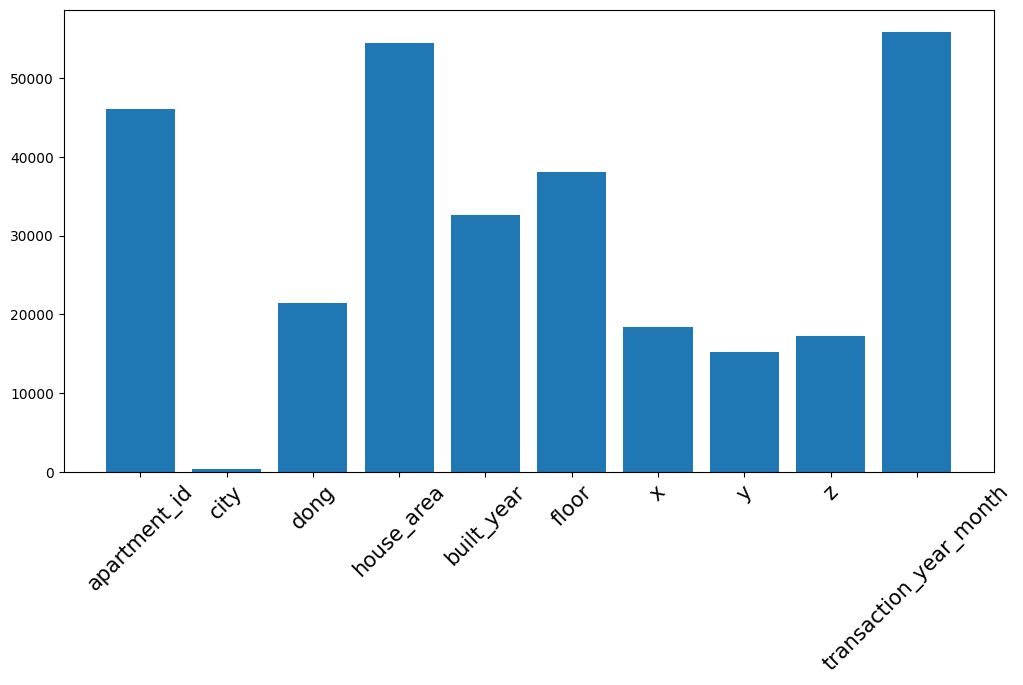

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(x=train_cols, height=np.mean(feature_importance, axis=0))
plt.xticks(fontsize=15, rotation=45)
plt.show()

From the above figure, we can see that `city` and `house_area` features are important to decrease the impurity after the tree split.

If you want more advanced feature importance analyses, please refer to this [link](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

# 5. Make submission

In [ ]:
train.groupby('transaction_year').mean().PRICE

transaction_year
2018    376279.168906
2019    382710.558311
2020    401518.870209
2021    432181.913400
2022    481308.249010
Name: PRICE, dtype: float64

In [ ]:
# the rate of increase in transaction_price every year

for year in range(2018, 2022):
  inc_rate = train.groupby('transaction_year').mean().PRICE[year+1] / train.groupby('transaction_year').mean().PRICE[year]
  print(f'{year}->{year+1}: {inc_rate}')

2018->2019: 1.0170920686998792
2019->2020: 1.0491450039452697
2020->2021: 1.0763676266954647
2021->2022: 1.1136705032908139


In [ ]:
(1.0170920686998792+1.0491450039452697+1.0763676266954647+1.1136705032908139) / 4

1.0640688006578567

In [ ]:
# Calibrates inflation in price

pred_test = np.mean(np.exp(test_pred), axis=0)*1.05

In [ ]:
pd.DataFrame({'index':test['index'].values, 'PRICE':pred_test}).to_csv('baseline.csv', index=False)